In [2]:
import orekit
from orekit.pyhelpers import setup_orekit_curdir, datetime_to_absolutedate,download_orekit_data_curdir

vm = orekit.initVM()

download_orekit_data_curdir()
setup_orekit_curdir()

from orekit.pyhelpers import datetime_to_absolutedate
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.frames import FramesFactory
from org.orekit.utils import IERSConventions
from org.orekit.models.earth import ReferenceEllipsoid
from org.orekit.bodies import CelestialBodyFactory
from org.orekit.models.earth.atmosphere.data import CssiSpaceWeatherData
from org.orekit.models.earth.atmosphere import DTM2000

OpenJDK 64-Bit Server VM warning: Attempt to protect stack guard pages failed.
OpenJDK 64-Bit Server VM warning: Attempt to deallocate stack guard pages failed.


In [4]:
cssi_sw_data = CssiSpaceWeatherData(CssiSpaceWeatherData.DEFAULT_SUPPORTED_NAMES)

In [11]:
test_datetime = datetime_to_absolutedate(datetime.datetime(2024, 5, 11, 0, 0, 0))
kp_24hr = cssi_sw_data.get24HoursKp(test_datetime)
Ap = cssi_sw_data.getAp(test_datetime)
avg_flux = cssi_sw_data.getAverageFlux(test_datetime)
daily_flux = cssi_sw_data.getDailyFlux(test_datetime)
instant_flux = cssi_sw_data.getInstantFlux(test_datetime)
mean_flux = cssi_sw_data.getMeanFlux(test_datetime)
three_hour_kp = cssi_sw_data.getThreeHourlyKP(test_datetime)
print(f"kp_24hr: {kp_24hr}")
print(f"Ap: {Ap}")
print(f"avg_flux: {avg_flux}")
print(f"daily_flux: {daily_flux}")
print(f"instant_flux: {instant_flux}")
print(f"mean_flux: {mean_flux}")
print(f"three_hour_kp: {three_hour_kp}")

kp_24hr: 8.375
Ap: JArray<double>[271.0, 400.0, 300.0, 300.0, 179.0, 10.25, 4.25]
avg_flux: 177.1
daily_flux: 223.4
instant_flux: 213.7
mean_flux: 177.1
three_hour_kp: 9.0


In [12]:
from pymsis import msis
from pymsis.utils import get_f107_ap
# Extract UTC dates
utc_date = datetime.datetime(2024, 5, 11, 0, 0, 0)

# Get f107, f107a, and ap_values
f107, f107a, ap_values = get_f107_ap(utc_date)
print(f"f107: {f107}")
print(f"f107a: {f107a}")
print(f"ap_values: {ap_values}")

f107: 223.4
f107a: 177.1
ap_values: [271.   400.   300.   300.   179.    10.25   4.25]


In [32]:
import numpy as np
from pyproj import Transformer

def lla_to_ecef(lat, lon, alt_km):
    """
    Convert Latitude, Longitude, Altitude (LLA) to Earth-Centered, Earth-Fixed (ECEF) coordinates.

    Parameters
    ----------
    lat : List[float]
        Latitudes in degrees.
    lon : List[float]
        Longitudes in degrees.
    alt_km : List[float]
        Altitudes in km.

    Returns
    -------
    tuple
        x, y, z coordinates in km.
    """
    # Convert altitude to meters
    alt_m = np.array(alt_km) * 1000

    # Create a transformer for converting between LLA and ECEF
    transformer = Transformer.from_crs(
        "EPSG:4326",  # WGS-84 (LLA)
        "EPSG:4978",  # WGS-84 (ECEF)
        always_xy=True  # Ensure consistent (lon, lat, alt) ordering
    )

    # Convert coordinates
    x_m, y_m, z_m = transformer.transform(lon, lat, alt_m)

    # Convert back to km
    x_km, y_km, z_km = x_m, y_m , z_m

    return x_km, y_km, z_km

In [69]:
#read LLA from grace density file

import pandas as pd
from pyproj import Transformer

def convert_csv_lla_to_ecef(input_file, output_file):
    # Read CSV file
    df = pd.read_csv(input_file)
    
    # Convert altitude from meters to km
    df["Alt_km"] = df["Alt"]/1000
    
    # Apply LLA to ECEF conversion
    df[["X_ecef", "Y_ecef", "Z_ecef"]] = df.apply(lambda row: pd.Series(lla_to_ecef(row["Lat"], row["Lon"], row["Alt_km"])), axis=1)
    
    # Save to new CSV file
    df.to_csv(output_file, index=False)
    
    print(f"Converted data saved to {output_file}")

# Example usage
convert_csv_lla_to_ecef("GRACE_density_feb_2022.csv", "GRACE_density_feb_2022_ecef.csv")

Converted data saved to GRACE_density_feb_2022_ecef.csv


In [70]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
from astropy.time import Time
from org.orekit.utils import PVCoordinates
from org.orekit.frames import FramesFactory, ITRFVersion

def utc_to_mjd(utc_time: datetime) -> float:
    """
    Convert UTC time (datetime object) to Modified Julian Date using Astropy,
    rounding to the nearest full second to avoid timing errors.
    """
    if utc_time.microsecond >= 500000:
        rounded_utc_time = utc_time + timedelta(seconds=1)
        rounded_utc_time = rounded_utc_time.replace(microsecond=0)
    else:
        rounded_utc_time = utc_time.replace(microsecond=0)
    
    time = Time(utc_time, format='datetime', scale='utc', precision=8)
    return time.mjd

def SP3_to_EME2000(itrs_pos, itrs_vel, mjds):
    # Orekit Frames
    frame_CTS = FramesFactory.getITRF(ITRFVersion.ITRF_2014, IERSConventions.IERS_2010, False)
    frame_EME2000 = FramesFactory.getEME2000()

    # Prepare output arrays
    eme2000_pos = np.empty_like(itrs_pos)
    eme2000_vel = np.empty_like(itrs_vel)

    # Iterate over each row of position, velocity, and corresponding MJD
    for i in range(len(itrs_pos)):
        # Convert MJD to Julian Date and then to UTC datetime
        mjd = mjds.iloc[i]
        jd = mjd + 2400000.5
        days_since_epoch = jd - 2400000.5
        base_date = datetime(1858, 11, 17)

        # Round the days to the nearest second before creating the timedelta
        # NOTE: this is to avoid floating point errors when creating the timedelta
        seconds_since_epoch = (days_since_epoch * 86400)
        seconds_since_epoch = round(days_since_epoch * 86400)
        dt = base_date + timedelta(seconds=seconds_since_epoch)
        dt = dt.replace(tzinfo=timezone.utc)

        # Convert datetime to AbsoluteDate
        absolute_date = datetime_to_absolutedate(dt)

        # Convert inputs to Orekit's Vector3D and PVCoordinates (and convert from km to m)
        itrs_pos_vector = Vector3D(float(itrs_pos[i, 0] * 1000), float(itrs_pos[i, 1] * 1000), float(itrs_pos[i, 2] * 1000))
        itrs_vel_vector = Vector3D(float(itrs_vel[i, 0] * 1000), float(itrs_vel[i, 1] * 1000), float(itrs_vel[i, 2] * 1000))
        pv_itrs = PVCoordinates(itrs_pos_vector, itrs_vel_vector)

        # Transform Coordinates
        cts_to_eme2000 = frame_CTS.getTransformTo(frame_EME2000, absolute_date)
        pveci = cts_to_eme2000.transformPVCoordinates(pv_itrs)

        # Extract position and velocity from transformed coordinates
        eme2000_pos[i] = [pveci.getPosition().getX(), pveci.getPosition().getY(), pveci.getPosition().getZ()]
        eme2000_vel[i] = [pveci.getVelocity().getX(), pveci.getVelocity().getY(), pveci.getVelocity().getZ()]

        # Convert back from m to km 
        eme2000_pos[i] = eme2000_pos[i] / 1000
        eme2000_vel[i] = eme2000_vel[i] / 1000

    return eme2000_pos, eme2000_vel

def convert_csv_ecef_to_eci(input_file, output_file):
    # Read CSV file
    df = pd.read_csv(input_file)
    
    # Convert UTC to MJD
    df["MJD"] = df["UTC"].apply(lambda x: utc_to_mjd(datetime.strptime(x, "%Y-%m-%d %H:%M:%S")))
    
    # Extract ECEF position
    ecef_positions = df[["X_ecef", "Y_ecef", "Z_ecef"]].values
    mjds = df["MJD"]
    
    # Convert ECEF to ECI
    eci_positions, eci_velocities = SP3_to_EME2000(ecef_positions, np.zeros_like(ecef_positions), mjds)
    
    # Add converted coordinates to DataFrame
    df[["X_eci", "Y_eci", "Z_eci"]] = eci_positions
    df[["Vx_eci", "Vy_eci", "Vz_eci"]] = eci_velocities
    
    # Save to new CSV file
    df.to_csv(output_file, index=False)
    
    print(f"Converted data saved to {output_file}")

# Example usage
# convert_csv_ecef_to_eci("input.csv", "output.csv")

# Example usage
convert_csv_ecef_to_eci("GRACE_density_feb_2022_ecef.csv", "GRACE_density_feb_2022_eci.csv")


Converted data saved to GRACE_density_feb_2022_eci.csv


In [71]:
# Plot every 1000th X_ECI_km, Y_ECI_km, Z_ECI_km in plotly 3D
sampled_df = df.iloc[::1000]
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=sampled_df['X_eci'],
    y=sampled_df['Y_eci'],
    z=sampled_df['Z_eci'],
    mode='markers',
    marker=dict(size=4, color='blue')
))

fig.update_layout(
    title='3D Scatter Plot of X_ECI_km, Y_ECI_km, Z_ECI_km',
    scene=dict(
        xaxis_title='X_eci',
        yaxis_title='Y_eci',
        zaxis_title='Z_eci'
    )
)

fig.show()


In [74]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
from astropy.time import Time
from tqdm import tqdm

def utc_to_mjd(utc_time: datetime) -> float:
    if utc_time.microsecond >= 500000:
        rounded_utc_time = utc_time + timedelta(seconds=1)
        rounded_utc_time = rounded_utc_time.replace(microsecond=0)
    else:
        rounded_utc_time = utc_time.replace(microsecond=0)
    
    time = Time(utc_time, format='datetime', scale='utc', precision=8)
    return time.mjd

def query_dtm2000(position, datetime):
    frame = FramesFactory.getEME2000()
    wgs84Ellipsoid = ReferenceEllipsoid.getWgs84(FramesFactory.getITRF(IERSConventions.IERS_2010, True))
    cssi_sw_data = CssiSpaceWeatherData(CssiSpaceWeatherData.DEFAULT_SUPPORTED_NAMES)
    sun = CelestialBodyFactory.getSun()
    atmosphere = DTM2000(cssi_sw_data, sun, wgs84Ellipsoid)
    absolute_date = datetime_to_absolutedate(datetime)
    position_vector = Vector3D(float(position[0]), float(position[1]), float(position[2]))
    density = atmosphere.getDensity(absolute_date, position_vector, frame)
    return density

def add_dtm2000_density_to_csv(input_file, output_file):
    df = pd.read_csv(input_file)
    
    densities = [None] * len(df)  # Preallocate list
    
    for i in tqdm(range(0, len(df), 50), total=len(df)//50, desc="Querying DTM2000 Density"):
        row = df.iloc[i]
        densities[i] = query_dtm2000([row["X_eci"], row["Y_eci"], row["Z_eci"]],datetime.strptime(row["UTC"], "%Y-%m-%d %H:%M:%S"))
    
    # Forward-fill missing values
    df["DTM2000_Density"] = pd.Series(densities).ffill()

    df.to_csv(output_file, index=False)
    
    print(f"Updated data with density saved to {output_file}")

# Example usage
add_dtm2000_density_to_csv("GRACE_density_feb_2022_eci.csv", "GRACE_density_feb_2022_dtm2000.csv")


Querying DTM2000 Density: 1037it [05:39,  3.05it/s]                          


Updated data with density saved to GRACE_density_feb_2022_dtm2000.csv


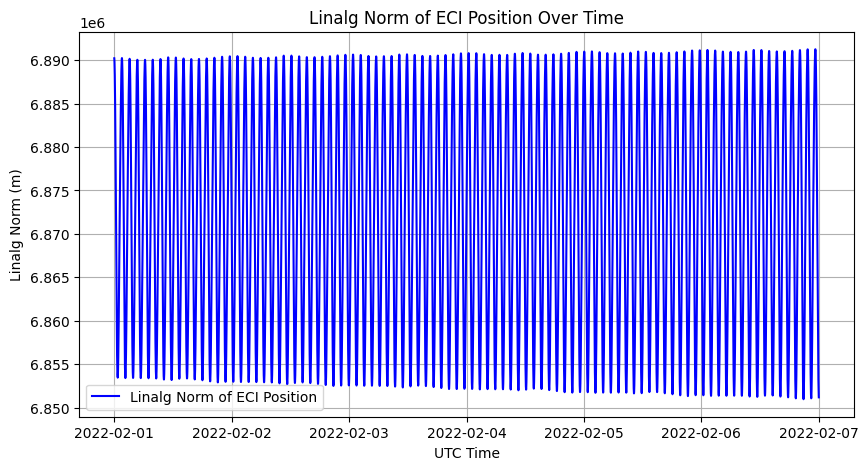

In [72]:
import matplotlib.pyplot as plt

def plot_linalg_norm(input_file):
    df = pd.read_csv(input_file)

    # Compute the linalg norm of the (X_eci, Y_eci, Z_eci) position vectors
    df["Position_Norm"] = np.linalg.norm(df[["X_eci", "Y_eci", "Z_eci"]], axis=1)

    # Convert UTC time to datetime
    df["UTC"] = pd.to_datetime(df["UTC"])

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df["UTC"], df["Position_Norm"], label="Linalg Norm of ECI Position", color="b")
    
    plt.xlabel("UTC Time")
    plt.ylabel("Linalg Norm (m)")
    plt.title("Linalg Norm of ECI Position Over Time")
    plt.legend()
    plt.grid()

    plt.show()

plot_linalg_norm("GRACE_density_feb_2022_eci.csv")

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
from astropy.time import Time
from tqdm import tqdm

def utc_to_mjd(utc_time: datetime) -> float:
    if utc_time.microsecond >= 500000:
        rounded_utc_time = utc_time + timedelta(seconds=1)
        rounded_utc_time = rounded_utc_time.replace(microsecond=0)
    else:
        rounded_utc_time = utc_time.replace(microsecond=0)
    
    time = Time(utc_time, format='datetime', scale='utc', precision=8)
    return time.mjd

def query_dtm2000(position, datetime):
    frame = FramesFactory.getEME2000()
    wgs84Ellipsoid = ReferenceEllipsoid.getWgs84(FramesFactory.getITRF(IERSConventions.IERS_2010, True))
    cssi_sw_data = CssiSpaceWeatherData(CssiSpaceWeatherData.DEFAULT_SUPPORTED_NAMES)
    sun = CelestialBodyFactory.getSun()
    atmosphere = DTM2000(cssi_sw_data, sun, wgs84Ellipsoid)
    absolute_date = datetime_to_absolutedate(datetime)
    position_vector = Vector3D(float(position[0]), float(position[1]), float(position[2]))
    density = atmosphere.getDensity(absolute_date, position_vector, frame)
    return density

def add_dtm2000_density_to_csv(input_file, output_file):
    df = pd.read_csv(input_file)
    
    densities = [None] * len(df)  # Preallocate list
    
    for i in tqdm(range(0, len(df), 50), total=len(df)//50, desc="Querying DTM2000 Density"):
        row = df.iloc[i]
        densities[i] = query_dtm2000([row["X_eci"], row["Y_eci"], row["Z_eci"]],datetime.strptime(row["UTC"], "%Y-%m-%d %H:%M:%S"))
        print(f"{row['UTC']} Density: {densities[i]} kg/m^3")
        print(f"linalg norm of position: {np.linalg.norm([row['X_eci'], row['Y_eci'], row['Z_eci']])}")
    
    # Forward-fill missing values
    df["DTM2000_Density"] = pd.Series(densities).ffill()

    df.to_csv(output_file, index=False)
    
    print(f"Updated data with density saved to {output_file}")

# Example usage
add_dtm2000_density_to_csv("GRACE_density_feb_2022_eci.csv", "GRACE_density_feb_2022_dtm2000.csv")


Querying DTM2000 Density:   0%|          | 1/1036 [00:00<06:29,  2.66it/s]

2022-02-01 00:00:00 Density: 1.8329623748746782e-19 kg/m^3
linalg norm of position: 528105207.7254815


Querying DTM2000 Density:   0%|          | 2/1036 [00:00<06:25,  2.68it/s]

2022-02-01 00:08:20 Density: 1.2408440685371137e-19 kg/m^3
linalg norm of position: 515920013.7438373


Querying DTM2000 Density:   0%|          | 3/1036 [00:01<05:59,  2.87it/s]

2022-02-01 00:16:40 Density: 8.968465677824464e-20 kg/m^3
linalg norm of position: 509113165.546513


Querying DTM2000 Density:   0%|          | 4/1036 [00:01<05:46,  2.98it/s]

2022-02-01 00:25:00 Density: 6.995638665381773e-20 kg/m^3
linalg norm of position: 508365171.4741844


Querying DTM2000 Density:   0%|          | 5/1036 [00:01<05:43,  3.00it/s]

2022-02-01 00:33:20 Density: 7.535240955600666e-20 kg/m^3
linalg norm of position: 506500262.62631214


Querying DTM2000 Density:   1%|          | 6/1036 [00:02<06:08,  2.80it/s]

2022-02-01 00:41:40 Density: 4.4919194171093927e-20 kg/m^3
linalg norm of position: 498832163.9549383


Querying DTM2000 Density:   1%|          | 7/1036 [00:02<06:28,  2.65it/s]

2022-02-01 00:50:00 Density: 3.783692314635637e-20 kg/m^3
linalg norm of position: 490443754.44149613


Querying DTM2000 Density:   1%|          | 8/1036 [00:02<06:12,  2.76it/s]

2022-02-01 00:58:20 Density: 5.598355951986572e-20 kg/m^3
linalg norm of position: 491647973.55022055


Querying DTM2000 Density:   1%|          | 9/1036 [00:03<05:57,  2.87it/s]

2022-02-01 01:06:40 Density: 1.406576089214515e-19 kg/m^3
linalg norm of position: 506162435.6197331


Querying DTM2000 Density:   1%|          | 10/1036 [00:03<05:47,  2.95it/s]

2022-02-01 01:15:00 Density: 2.816623716057933e-19 kg/m^3
linalg norm of position: 525362864.7386278


Querying DTM2000 Density:   1%|          | 11/1036 [00:03<06:04,  2.81it/s]

2022-02-01 01:23:20 Density: 2.088063107001244e-19 kg/m^3
linalg norm of position: 535866274.56619114


Querying DTM2000 Density:   1%|          | 12/1036 [00:04<06:03,  2.82it/s]

2022-02-01 01:31:40 Density: 1.7829085151700927e-19 kg/m^3
linalg norm of position: 531932298.4122882


Querying DTM2000 Density:   1%|          | 12/1036 [00:04<06:35,  2.59it/s]


KeyboardInterrupt: 

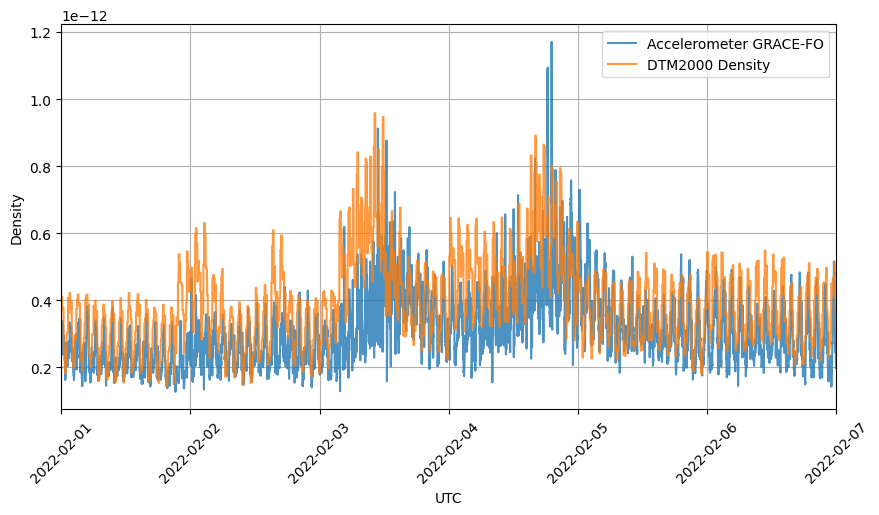

In [78]:


import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
file_path = 'GRACE_density_feb_2022_dtm2000.csv'  # Replace with the actual file path
df = pd.read_csv(file_path)

# Convert UTC column to datetime
df['UTC'] = pd.to_datetime(df['UTC'])

# Plot dens_x and DTM2000_Density vs UTC
plt.figure(figsize=(10, 5))
plt.plot(df['UTC'], df['dens_x'], label='Accelerometer GRACE-FO', linestyle='-', marker='', alpha=0.8)
plt.plot(df['UTC'], df['DTM2000_Density'], label='DTM2000 Density', linestyle='-', marker='', alpha=0.8)

#force the y axis to go from to 1.2 e-12
# plt.ylim(0, 1.2e-12) 
#force the x axis to start on the 01-02-2022 and end on the 07-02-2022
plt.xlim(pd.Timestamp('2022-02-01'), pd.Timestamp('2022-02-07'))

# Formatting
plt.xlabel('UTC')
plt.ylabel('Density')
# plt.title('Density Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.show()


In [31]:
import plotly.graph_objects as go

# Plot every 1000th X_ECI_km, Y_ECI_km, Z_ECI_km in plotly 3D
sampled_df = df.iloc[:1000]
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=sampled_df['X_ECI_km'],
    y=sampled_df['Y_ECI_km'],
    z=sampled_df['Z_ECI_km'],
    mode='markers',
    marker=dict(size=1, color='blue')
))

fig.update_layout(
    title='3D Scatter Plot of X_ECI_km, Y_ECI_km, Z_ECI_km',
    scene=dict(
        xaxis_title='X_ECI_km',
        yaxis_title='Y_ECI_km',
        zaxis_title='Z_ECI_km'
    )
)

fig.show()